# Testing DEMV on Drug Dataset

- Sensitive group: white women (`race: 1, gender: 0`)
- Positive label: never (0)

In [18]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, GridSearch

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [19]:
def prepare_data():
  data = pd.read_csv('data2/drugs.csv')
  data.drop(['yhat','a'], axis=1, inplace=True)
  data.loc[data['gender']==0.48246,'gender']=1
  data.loc[data['gender']==-0.48246,'gender']=0
  data['y'].replace({
    'never': 0,
    'not last year': 1,
    'last year': 2}, inplace=True)
  data['race'].replace({
    'non-white': 0,
    'white': 1}, inplace=True)
  string_cols = data.dtypes[data.dtypes == 'object'].index.values
  data.drop(string_cols, axis=1, inplace=True)
  return data


In [20]:
data = prepare_data()

In [21]:
data

,id,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,y,race
0,1,0.49788,1.0,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0,0
1,2,-0.07854,0.0,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,2,1
2,3,0.49788,0.0,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,2,1
3,4,-0.95197,1.0,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,1
4,5,0.49788,1.0,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,-0.95197,1.0,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,2,1
1881,1885,-0.95197,0.0,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,2,1
1882,1886,-0.07854,1.0,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,2,1
1883,1887,-0.95197,1.0,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,2,1


In [22]:
label = 'y'
protected_group = {'race': 1, 'gender': 0}
positive_label = 0
sensitive_features = ['race', 'gender']

In [23]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(n_jobs=-1))
])

## Biased classifier

In [24]:
model, lr_bias, pred = cross_val2(pipeline, data, label, protected_group, sensitive_features, positive_label)
print_metrics(lr_bias)

Statistical parity:  -0.299  +-  0.052
Disparate impact:  0.142  +-  0.081
Zero one loss:  0.335  +-  0.098
F1 score:  0.67  +-  0.023
Accuracy score:  0.68  +-  0.025


## DEMV application

In [25]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [26]:
model, lr_demv = cross_val(pipeline, demv_data, label, protected_group, sensitive_features, debiaser=demv, positive_label=positive_label)
print_metrics(lr_demv)

Statistical parity:  -0.147  +-  0.053
Disparate impact:  0.493  +-  0.144
Zero one loss:  0.327  +-  0.116
F1 score:  0.663  +-  0.028
Accuracy score:  0.675  +-  0.027


## DEMV Evaluation

In [27]:
demv.get_iters()

89

In [28]:
metrics = eval_demv(17, 89, data.copy(), pipeline, label, protected_group, sensitive_features, positive_label=positive_label)

##  Blackbox Postprocessing

In [29]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [30]:
data.loc[:,"combined"] = 0
data.loc[(data['race'] == 1) & (data["gender"] == 0),"combined"] = 1

In [31]:
#Now pred contains the actual values on column "y_true" and predicted values on column "contr_use"

pred.loc[:,"combined"] = 0
pred.loc[(pred['race'] == 1) & (pred["gender"] == 0),"combined"] = 1

In [32]:
y_pred = pred[label].values
y_true = pred['y_true'].values

In [33]:
import tools
stats = tools.clf_metrics(y_true, y_pred)
stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,556.0,209.0,938.0,182.0,0.6801,0.803,0.6643,0.8367,0.4831,0.6704,0.4919,0.2074,0.0,0.0,739.0,765.0,27.0,-0.0


In [34]:
blackboxmetrics = blackboxCVmetrics( data, label, y_true, unpriv_group, pred )


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.1029  0.3667
1  0.3026  0.5000
2  0.2308  0.7391

1
      fpr     tpr
0  0.0125  0.5455
1  0.1143  0.5238
2  0.3125  0.9322


And loss is 0.3228


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.1000  0.3929
1  0.2794  0.5000
2  0.2500  0.7500

1
      fpr     tpr
0  0.0139  0.6000
1  0.1250  0.5000
2  0.2857  0.9259


And loss is 0.3176

[0.39285715 0.484409   0.12273385]
[0.20000001 0.6281726  0.17182739]
[0.05       0.52043153 0.42956847]
[0.39285715 0.58930632 0.01783653]
[0.15899737 0.6281726  0.21283003]
[0.08033422 0.49009732 0.42956847]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.1167  0.4074
1  0.2879  0.4762
2  0.2500  0.7179

1
      fpr     tpr
0  0.0139  0.5455
1  0.1129  0.5238
2  0.3125  0.9412


And loss is 0.3294

[0.40740741 0.44843954 0.14415305]
[0.23809524 0.57656512 0.18533963]
[0.05128205 0.48299272 0.46572523]
[0.40740741 0.53565224 0.05694035]
[0.20614126 0.57656512 0.21729362]


##  Plot

In [35]:
df = prepareplots(metrics, 'drugs')
# df = pd.read_csv('ris/drugs_eval.csv')

In [36]:
points = preparepoints(blackboxmetrics, 85)

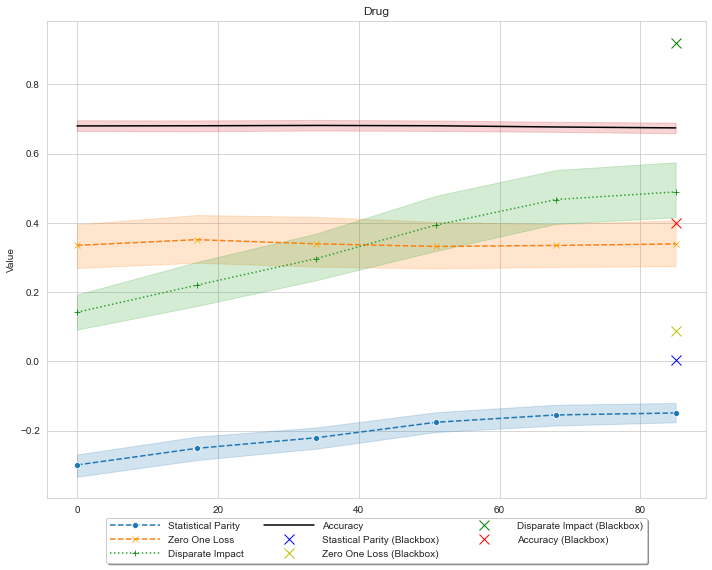

In [37]:
plot_metrics_curves(df, points, 'Drug')

In [38]:
unprivpergentage(data, protected_group, 89)

Dataset size: 1885
Unprivileged group size: 863
Percentage of unprivileged group: 45.782493368700266
Number of iterations: 89
